In [1]:
import yfinance as yh
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
from datetime import datetime
import pytz
from datetime import datetime, timedelta
#import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
#import shap
import numpy as np
import utils as ut
from sklearn.ensemble import RandomForestClassifier
import warnings
import pickle
from pycaret.classification import *
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
warnings.filterwarnings("ignore")

In [2]:
var = ['signal_bollinger_12_1', 'signal_bollinger_12_2', 'signal_bollinger_20_1',
        'signal_bollinger_20_2', 'RSI_14_30_70', 'signal_rsi_14_30_70', 'RSI_14_20_80',
        'signal_rsi_14_20_80', 'RSI_8_30_70', 'signal_rsi_8_30_70', 'RSI_8_20_80',
        'signal_rsi_8_20_80', 'Stochastic_K_14_3', 'Stochastic_D_14_3', 'Stochastic_K_14_5',
        'Stochastic_D_14_5', 'Stochastic_K_8_3', 'Stochastic_D_8_3', 'Stochastic_K_8_5', 
        'Stochastic_D_8_5', 'signal_atr_14_1', 'signal_atr_14_1.5', 'signal_atr_8_1', 
        'signal_atr_8_1.5', 'signal_atr_30_1', 'signal_atr_30_1.5', 'OBV_trend',
        'signal_obv_1', 'signal_obv_3', 'signal_obv_4', 'Williams_R_14',
        'Williams_R_8', 'Williams_R_30', 'adx_14', 'adx_8', 'adx_30',
        'Aroon_Oscillator_14', 'Aroon_Oscillator_8', 'Aroon_Oscillator_30',
        'Keltner_20_1.5', 'Keltner_20_2', 'Keltner_20_2.5', 'Keltner_14_1.5',
        'Keltner_14_2', 'Keltner_14_2.5', 'Keltner_8_1.5', 'Keltner_8_2',
        'Keltner_8_2.5', 'CMF_20', 'CMF_14','CMF_8']

In [3]:
data = pl.read_csv('stocks_data.csv')

data = data.with_columns(
    pl.col("Date")
    .str.strptime(pl.Datetime, "%+").dt.replace_time_zone(None)
    .alias("Date"),

    pl.when(pl.col('daily_return').shift(-1)>0.017261).then(2).when(pl.col('daily_return').shift(-1)<-0.013486).then(1).otherwise(0).alias("target_5"),
    pl.when(pl.col('daily_return').shift(-1)>0).then(1).otherwise(0).alias("target_6")
)

data_stock = data.filter(pl.col('Symbol')=='ASML')

In [4]:
data_stock.filter(pl.col('period')=='train').select(pl.col('daily_return')).describe()

statistic,daily_return
str,f64
"""count""",977.0
"""null_count""",0.0
"""mean""",0.001226
"""std""",0.027416
"""min""",-0.173491
"""25%""",-0.013486
"""50%""",0.000543
"""75%""",0.017261
"""max""",0.145732


In [5]:
target = 'target_5'
data_train = data_stock.filter(pl.col('period')=='train').select(var+[target]+['Date']).to_pandas()
data_test= data_stock.filter(pl.col('period')=='test').select(var+[target]+['Date']).to_pandas()
data_train = data_train.set_index('Date')
data_test = data_test.set_index('Date')

X_train = data_train[var]
y_train = data_train.target_5

model = RandomForestClassifier(random_state=8, class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 5],
    #'min_samples_split': [2, 5, 10]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 5, 'n_estimators': 50}


In [7]:
X_train = data_stock.filter(pl.col('period')=='train').select(var)
y_train = data_stock.filter(pl.col('period')=='train').select("target_5")

X_test = data_stock.filter(pl.col('period')=='test').select(var)
y_test = data_stock.filter(pl.col('period')=='test').select("target_5")

In [8]:

clf = RandomForestClassifier(max_depth=10, random_state=8, class_weight='balanced', n_estimators= 50)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=50,
                       random_state=8)

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

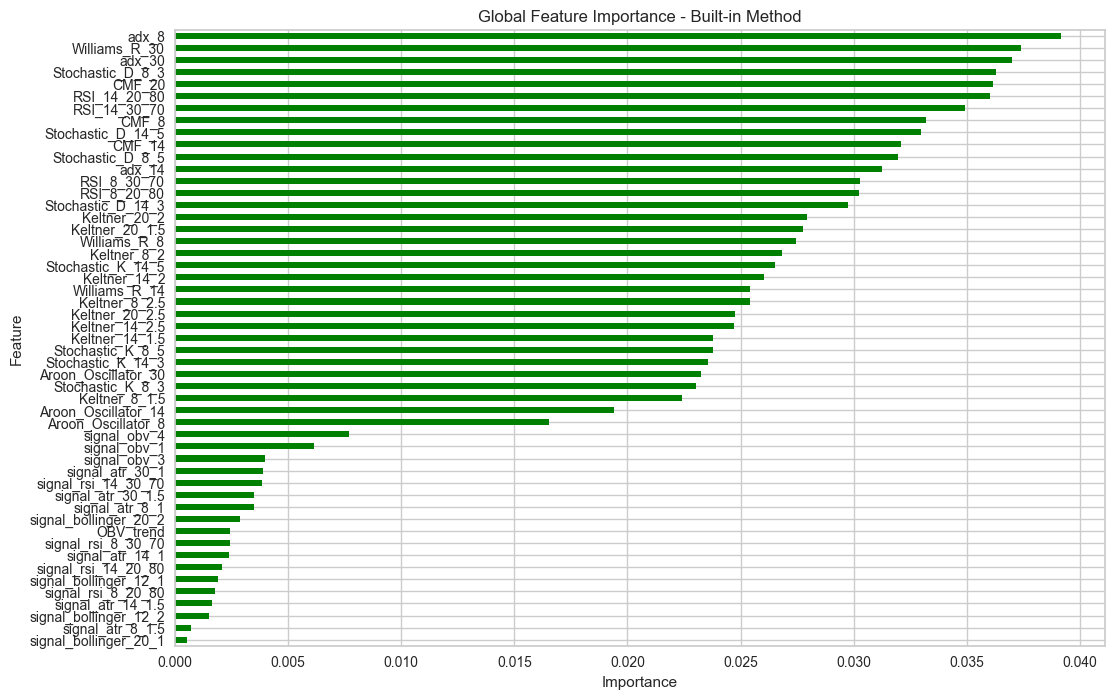

In [9]:
global_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green', figsize=(12, 8))
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

(4.319715515136719, 0.0034971083954641546, 0.0017200568379513125, 7.807895185664591)
(0.3657911682128907, 0.011005661295484715, 0.0003799294955769632, 0.5480083026617917)


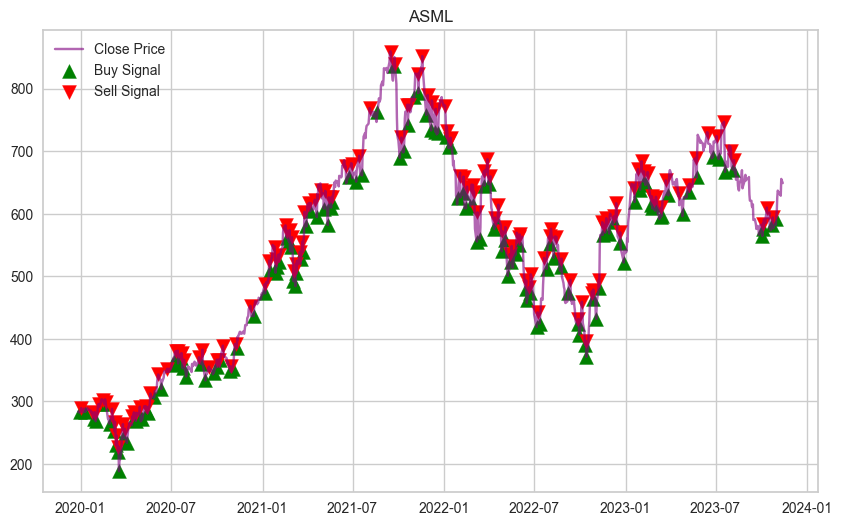

In [10]:
symbol = "ASML"
df_test = data_stock.filter(pl.col('period')=='train')
df_orders = ut.generate_orders(df_test, 1, 1000, clf, var)
print(ut.get_stats(df_orders.portfolio_value))
print(ut.get_stats(df_orders.portfolio_value_2))
ut.plot_signal(df_orders, symbol)

(0.08472967529296871, 0.018634221426919097, 0.0005012428607419066, 0.4270091866743244)
(-0.0008512573242187571, 0.020517757418479464, 0.00020960250335207232, 0.16216862888144903)


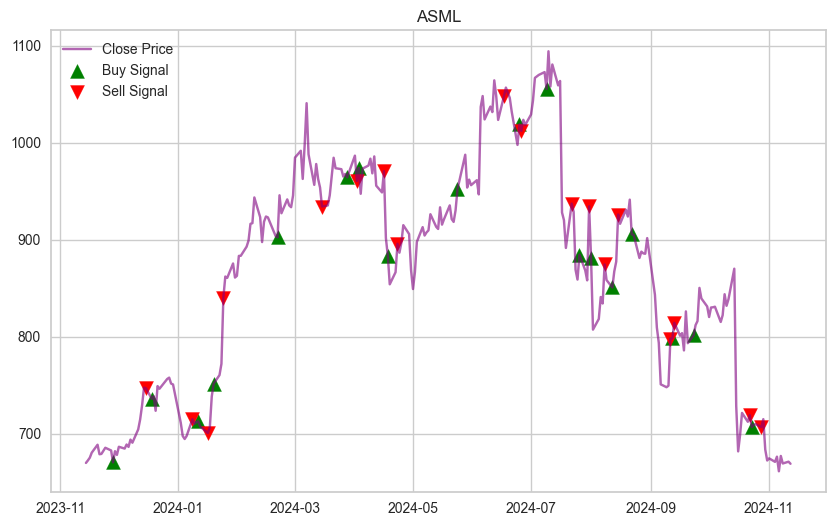

In [11]:
symbol = "ASML"
df_test = data_stock.filter(pl.col('period')=='test')
df_orders = ut.generate_orders(df_test, 1, 1000, clf, var)
print(ut.get_stats(df_orders.portfolio_value))
print(ut.get_stats(df_orders.portfolio_value_2))
ut.plot_signal(df_orders, symbol)

# Other Classifiers

In [12]:
target = 'target_5'
data_train = data_stock.filter(pl.col('period')=='train').select(var+[target]).to_pandas()
data_test= data_stock.filter(pl.col('period')=='test').select(var+[target]).to_pandas()


In [13]:
exp_mclf101 = setup(data = data_train, target = target, session_id=1978, fix_imbalance=False) 

,Description,Value
0,Session id,1978
1,Target,target_5
2,Target type,Multiclass
3,Original data shape,"(977, 52)"
4,Transformed data shape,"(977, 52)"
5,Transformed train set shape,"(683, 52)"
6,Transformed test set shape,"(294, 52)"
7,Numeric features,51
8,Preprocess,True
9,Imputation type,simple


In [14]:
compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:42:27
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.4993,0.5000,0.4993,0.2493,0.3325,0.0000,0.0000,0.0100
knn,K Neighbors Classifier,0.4671,0.5414,0.4671,0.4087,0.4093,0.0548,0.0624,0.4390
ridge,Ridge Classifier,0.4599,0.0000,0.4599,0.4016,0.3978,0.0295,0.0345,0.0100
lda,Linear Discriminant Analysis,0.4512,0.5684,0.4512,0.4103,0.4060,0.0351,0.0395,0.0110
gbc,Gradient Boosting Classifier,0.4509,0.5482,0.4509,0.4024,0.4041,0.0347,0.0383,0.3780
lr,Logistic Regression,0.4497,0.5672,0.4497,0.3884,0.3937,0.0226,0.0251,0.6370
et,Extra Trees Classifier,0.4466,0.5449,0.4466,0.3960,0.4031,0.0319,0.0338,0.0490
rf,Random Forest Classifier,0.4465,0.5507,0.4465,0.3735,0.3869,0.0141,0.0144,0.0720
lightgbm,Light Gradient Boosting Machine,0.4362,0.5389,0.4362,0.4076,0.4115,0.0448,0.0470,0.6850
ada,Ada Boost Classifier,0.4320,0.5242,0.4320,0.3934,0.3961,0.0214,0.0231,0.0410


DummyClassifier(constant=None, random_state=1978, strategy='prior')

In [81]:
nb = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4783,0.5761,0.4783,0.4819,0.4628,0.1946,0.2029
1,0.4058,0.5602,0.4058,0.4540,0.4161,0.1095,0.1132
2,0.3623,0.5159,0.3623,0.3265,0.3386,-0.0469,-0.0482
3,0.3088,0.4661,0.3088,0.3507,0.3247,-0.0562,-0.0573
4,0.5294,0.6458,0.5294,0.5224,0.5140,0.2515,0.2580
5,0.4265,0.5418,0.4265,0.4225,0.4135,0.0545,0.0558
6,0.3824,0.5763,0.3824,0.4303,0.3887,0.0508,0.0544
7,0.3676,0.5342,0.3676,0.3876,0.3753,0.0171,0.0173
8,0.4853,0.6326,0.4853,0.5121,0.4921,0.1954,0.1986


(0.41631964111328124, 0.007924445121946011, 0.0003880371813806878, 0.7773287837175266)
(0.3657911682128907, 0.011005661295484715, 0.0003799294955769632, 0.5480083026617917)


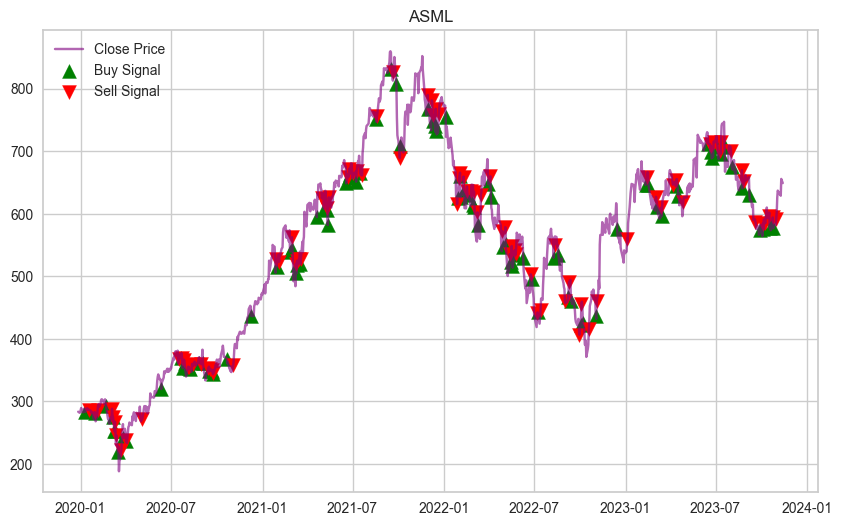

In [82]:
symbol = "ASML"
df_test = data_stock.filter(pl.col('period')=='train')
df_orders = ut.generate_orders(df_test, 1, 1000, nb, var)
print(ut.get_stats(df_orders.portfolio_value))
print(ut.get_stats(df_orders.portfolio_value_2))
ut.plot_signal(df_orders, symbol)

(0.08876947021484383, 0.015577793283734516, 0.000462369190858376, 0.47117606606838464)
(-0.0008512573242187571, 0.020517757418479464, 0.00020960250335207232, 0.16216862888144903)


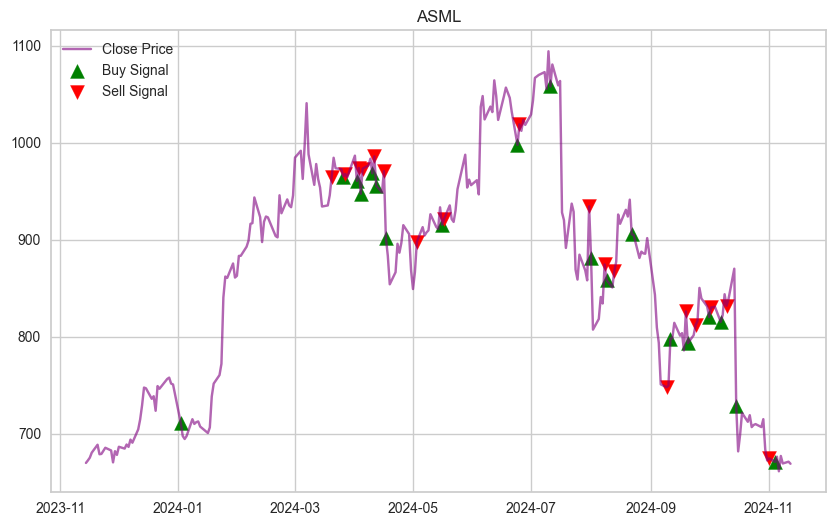

In [83]:
symbol = "ASML"
df_test = data_stock.filter(pl.col('period')=='test')
df_orders = ut.generate_orders(df_test, 1, 1000, nb, var)
print(ut.get_stats(df_orders.portfolio_value))
print(ut.get_stats(df_orders.portfolio_value_2))
ut.plot_signal(df_orders, symbol)